# Packages

In [1]:
import pandas as pd
import pytz,dateutil
import datetime, pytz
import numpy as np
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

In [2]:
#load the dataset 
data = pd.read_csv('D:/作业/BeatCorn/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv',parse_dates=[0], date_parser=dateparse) 
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

In [43]:
# split data
split_date = '01-Mar-2021'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [44]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

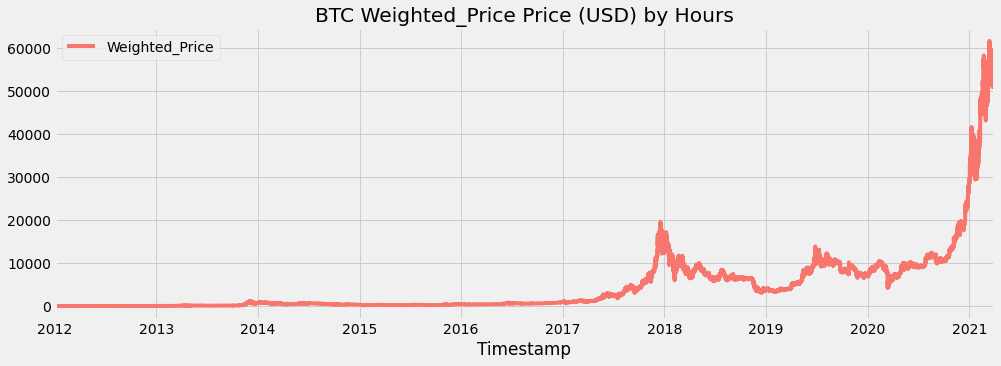

In [45]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

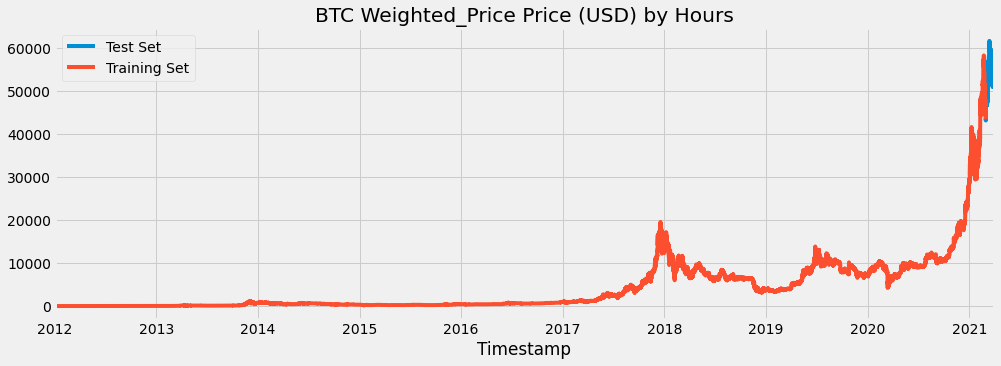

In [46]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

# Time Series forecasting with LSTM

In [47]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
 - 5s - loss: 0.0163
Epoch 2/100
 - 4s - loss: 0.0033
Epoch 3/100
 - 4s - loss: 0.0017
Epoch 4/100
 - 5s - loss: 0.0011
Epoch 5/100
 - 5s - loss: 7.8194e-04
Epoch 6/100
 - 5s - loss: 6.0228e-04
Epoch 7/100
 - 5s - loss: 4.8265e-04
Epoch 8/100
 - 5s - loss: 3.9628e-04
Epoch 9/100
 - 5s - loss: 3.3030e-04
Epoch 10/100
 - 5s - loss: 2.8441e-04
Epoch 11/100
 - 5s - loss: 2.4221e-04
Epoch 12/100
 - 5s - loss: 2.2338e-04
Epoch 13/100
 - 5s - loss: 2.0258e-04
Epoch 14/100
 - 5s - loss: 1.8813e-04
Epoch 15/100
 - 5s - loss: 1.7937e-04
Epoch 16/100
 - 5s - loss: 1.6424e-04
Epoch 17/100
 - 5s - loss: 1.6310e-04
Epoch 18/100
 - 5s - loss: 1.5762e-04
Epoch 19/100
 - 5s - loss: 1.5492e-04
Epoch 20/100
 - 5s - loss: 1.5561e-04
Epoch 21/100
 - 5s - loss: 1.4529e-04
Epoch 22/100
 - 5s - loss: 1.4478e-04
Epoch 23/100
 - 5s - loss: 1.4554e-04
Epoch 24/100
 - 5s - loss: 1.4898e-04
Epoch 25/100
 - 5s - loss: 1.3893e-04
Epoch 26/100
 - 5s - loss: 1.4598e-04
Epoch 27/100
 - 5s - loss: 1.4061e-04

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Making the predictions
import math
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [50]:
data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

In [51]:
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Timestamp','Weighted_Price','lstm']]

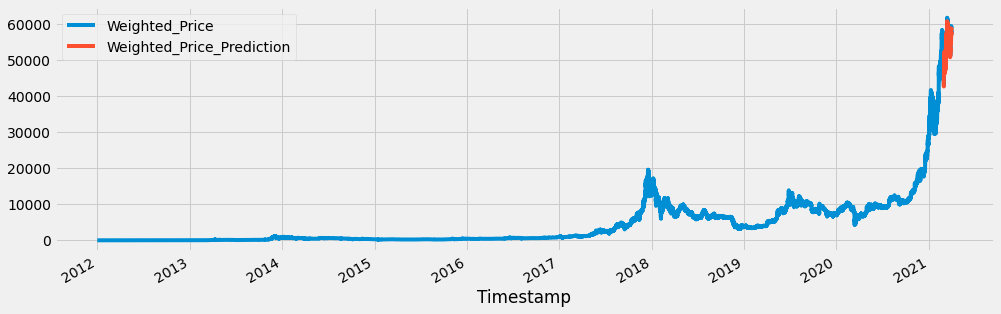

In [52]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

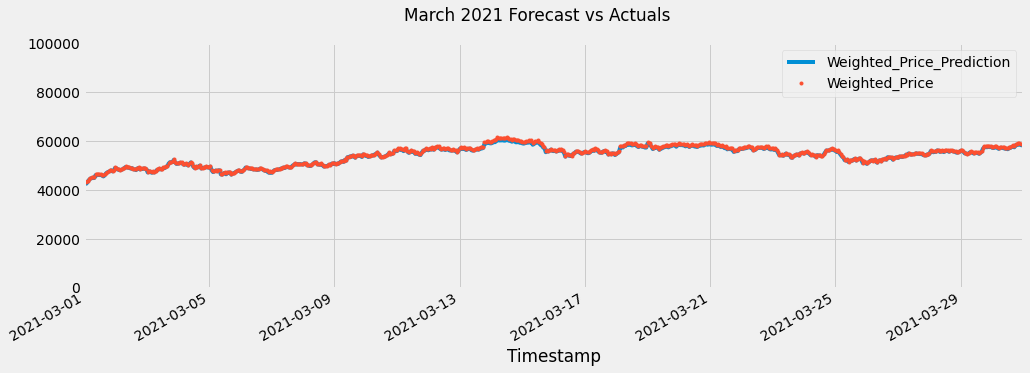

In [53]:
import matplotlib.pyplot as plt
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='03-01-2021', upper='03-31-2021')
ax.set_ylim(0, 100000)
plot = plt.suptitle('March 2021 Forecast vs Actuals')

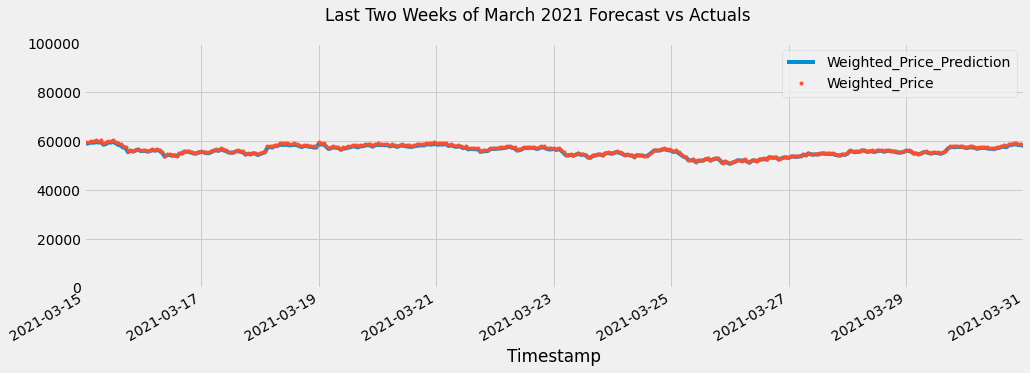

In [54]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='03-15-2021', upper='03-31-2021')
ax.set_ylim(0, 100000)
plot = plt.suptitle('Last Two Weeks of March 2021 Forecast vs Actuals')

In [55]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

159322.5886084204

In [56]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

368.3227587283654

In [57]:
from math import sqrt
from sklearn.metrics import r2_score
y_true=data_test['Weighted_Price']
y_pred=data_test['Weighted_Price_Prediction']
print("mean_absolute_error:", mean_absolute_error(y_true, y_pred))  
print("mean_squared_error:", mean_squared_error(y_true, y_pred))
print("rmse:", sqrt(mean_squared_error(y_true, y_pred)))
print("r2 score:", r2_score(y_true, y_pred))   

mean_absolute_error: 368.3227587283654
mean_squared_error: 159322.5886084204
rmse: 399.15233759608674
r2 score: 0.9896144705407937


# Time Series forecasting with XGBoost

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [59]:
data = pd.read_csv('D:/作业/BeatCorn/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv',parse_dates=[0], date_parser=dateparse) 
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

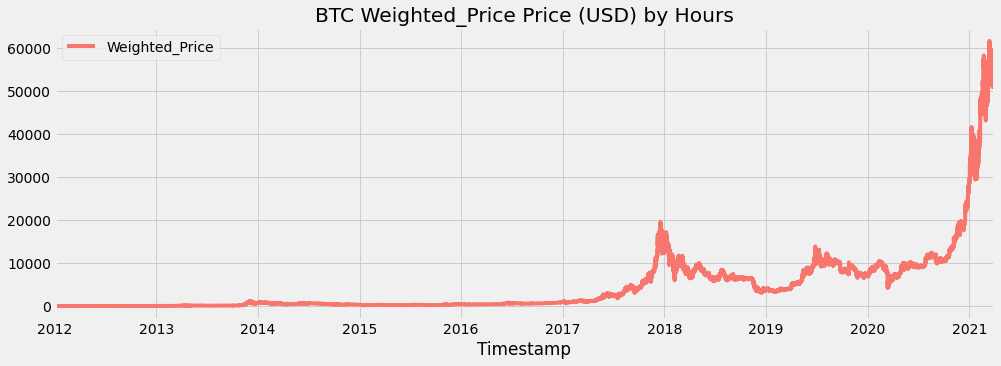

In [60]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

In [61]:
split_date = '01-Mar-2021'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

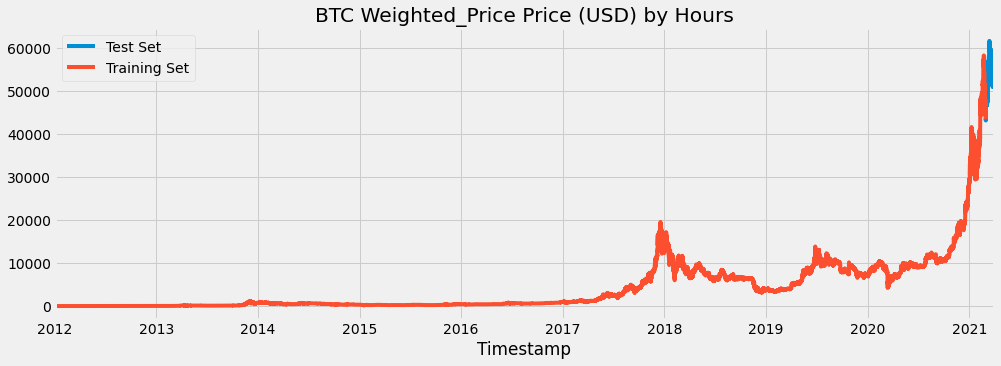

In [62]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [63]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [64]:
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [65]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[15:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [66]:
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

D:\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [67]:
#adding to final data for comparision
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'xgboost'})
final_data = final_data[['Timestamp','Weighted_Price','lstm','xgboost']]

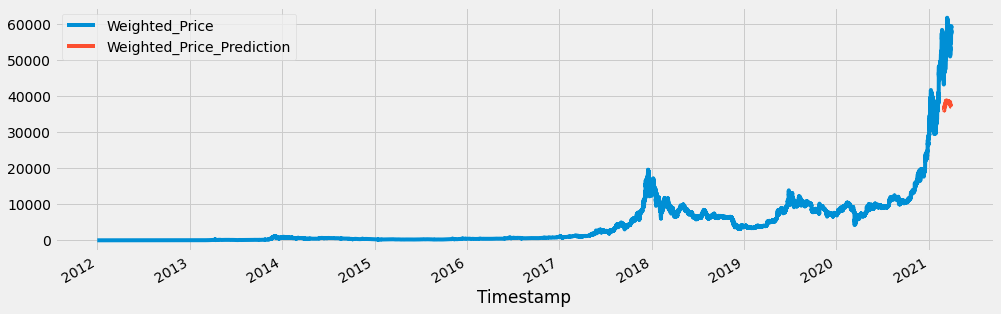

In [68]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

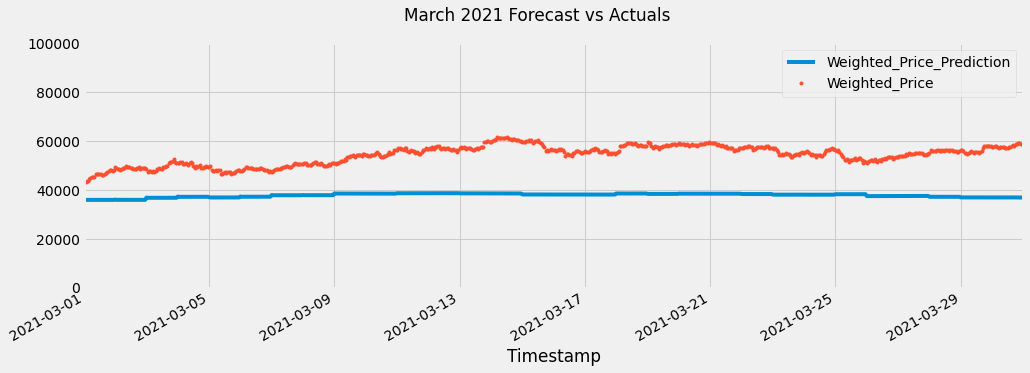

In [69]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='03-01-2021', upper='03-31-2021')
ax.set_ylim(0, 100000)
plot = plt.suptitle('March 2021 Forecast vs Actuals')

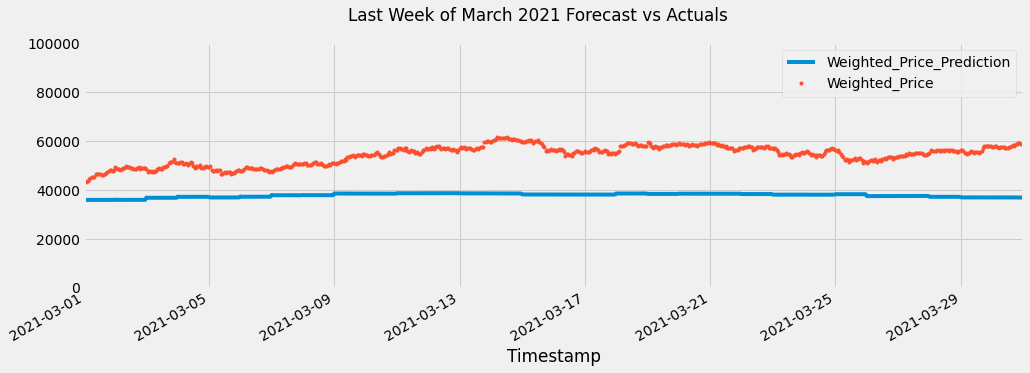

In [70]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='03-01-2021', upper='03-31-2021')
ax.set_ylim(0, 100000)
plot = plt.suptitle('Last Week of March 2021 Forecast vs Actuals')

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

287345871.15282404

In [72]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

16591.17061887603